In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import log
import csv
import string 
import matplotlib.pyplot as plt
import random

In [38]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

     Position                 Price
0         Buy   [5191.725117978507]
1    Buy Main   [4868.713947753906]
2        Sell   [5144.037007376565]
3   Sell Main            [5047.947]
4         Buy   [5035.909730733385]
5    Buy Main   [3327.624348876953]
6        Sell   [5095.767631441884]
7   Sell Main          [3767.47875]
8         Buy  [4989.0622039612535]
9    Buy Main  [3504.2507499999997]
10       Sell   [5281.337687092825]
11  Sell Main   [4343.502247558594]
Profit/Loss:  [7596.14002788]
Mean:  -0.4897477467019877 Variance:  2.867578252195462


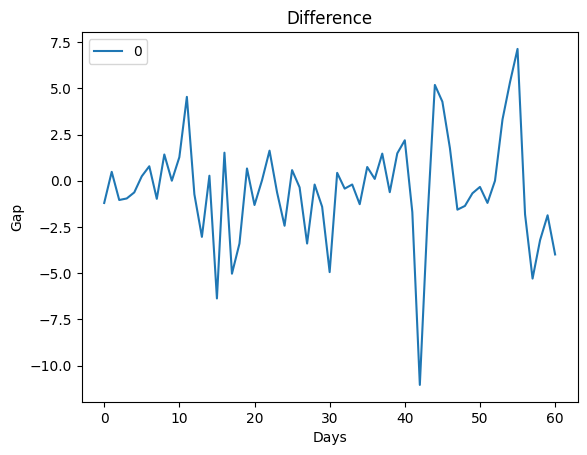

In [39]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']

#Calculates price action of the stocks in holding according to their weights.
def calculate_weighted_price(stock_data_dict, weights, start_date, end_date):
    # Download closing prices for all stocks
    price_data = pd.DataFrame({ticker: list(fetch_stock_data(ticker, start_date, end_date).values) for ticker in stock_data_dict})
    # Align dates and drop rows with missing values
    price_data.dropna(inplace=True)

    # Convert weights to a Pandas Series aligned with columns
    weights_series = pd.Series(weights, index=price_data.columns)

    # Calculate weighted prices
    weighted_price = price_data.dot(weights_series)
    return weighted_price

'''def plot_weighted_price_and_correlation(stock_data_dict, weights, additional_stock_data, additional_stock_label, start_date, end_date):
    # Calculate the weighted price
    weighted_price = calculate_weighted_price(stock_data_dict, weights, start_date, end_date)
    
    # Create a DataFrame with both series
    df = pd.DataFrame({'Weighted_Price': list(weighted_price), additional_stock_label: additional_stock_data})

    # Calculate correlation using Pandas
    correlation = df.corr().loc['Weighted_Price', additional_stock_label]
    print(f'Correlation between the weighted price index and {additional_stock_label}: {correlation:.2f}')

    # Plot the data
    df.plot()
    plt.title('Weighted Price Index with Additional Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()'''

#Calculates the gap in returns of the weighted holding stocks and the main holding company's returns. Then stores them into list.
def plot_return_gap(stock_data_dict, additional_stock_label, weights, start_date, end_date, b):
    holding_returns = log_returns(stock_data_dict, weights, 1, start_date, end_date, b)
    main_company_returns = log_returns(additional_stock_label, weights, 0, start_date, end_date, b)
    list = []
    for i in range(len(holding_returns)):
        if str(holding_returns[i]-main_company_returns[i]) != 'nan':
            list.append(main_company_returns[i]-holding_returns[i])
        else: continue
    
    # Plot the weighted price index with the additional stock and calculate correlation
    data = pd.DataFrame(list)
    data.plot()
    plt.title('Difference')
    plt.xlabel('Days')
    plt.ylabel('Gap')
    plt.legend()
    plt.show()

def return_gap(stock_data_dict, additional_stock_label, weights, start_date, end_date, b):
    holding_returns = log_returns(stock_data_dict, weights, 1, start_date, end_date, b)
    main_company_returns = log_returns(additional_stock_label, weights, 0, start_date, end_date, b)
    list = []
    for i in range(len(holding_returns)):
        if str(holding_returns[i]-main_company_returns[i]) != 'nan':
            list.append(main_company_returns[i]-holding_returns[i])
        else: continue
    return list

#Calculate returns in a n day window. n=5
def log_returns(stock_data_dict, weights, isIndex, start_date, end_date, b):
    log_price = []
    if isIndex == 1:
        price_data = calculate_weighted_price(stock_data_dict, weights, start_date, end_date).values
    else:
        price_data = yf.download(stock_data_dict, start=start_date, end=end_date)['Close'].values
    for i in range(b, len(price_data)):
        log_price.append((log(price_data[i]/price_data[i-b])-1)*100)
    return log_price

# Creates a Trade Log
def trade_book():
    tradelog = pd.DataFrame(columns = ['Position', 'Price'])
    return tradelog

#Defines entry and exit.
def entry_exit(list, main_company_price_data, holding_price_data, a):
    tradebook = trade_book()
    max=0
    for i in range(len(list)):
        if max == 0:
            if list[i]>np.std(list)+a:
                max = 1
                tradebook.loc[len(tradebook)] = ["Buy", holding_price_data[i]*1.001]
                tradebook.loc[len(tradebook)] = ["Buy Main", main_company_price_data[i]*1.001]
        if max == 1 :
            if list[i]<np.mean(list)+a:
                tradebook.loc[len(tradebook)] = ["Sell", holding_price_data[i]*0.999]
                tradebook.loc[len(tradebook)] = ["Sell Main", main_company_price_data[i]*0.999]
                max = 0
    return tradebook     

#Calculates PnL
def pnl(list, main_company_price_data, holding_price_data, a, c):
    tradebook = entry_exit(list, main_company_price_data, holding_price_data, a)
    buying = tradebook.loc[tradebook['Position'] == 'Buy']['Price'].sum() + c*tradebook.loc[tradebook['Position'] == 'Buy Main']['Price'].sum()
    selling = tradebook.loc[tradebook['Position'] == 'Sell']['Price'].sum() + c*tradebook.loc[tradebook['Position'] == 'Sell Main']['Price'].sum()
    if buying==0:
        return selling-buying
    #print(selling-buying)
    return selling-buying


'''stocks = ['ABREL.NS', 'KESORAMIND.NS', 'MANGLMCEM.NS', 'ULTRACEMCO.NS', 'ABFRL.NS','IDEA.NS','PILANIINVS.NS']
weights = [0.482, 0.087, 0.012, 0.391,0.010, 0.019]  # You can customize the weights as per your preference

# User input for date range
start_date = '2021-01-01'
end_date = '2025-01-31'

# Fetch stock data
stock_data_dict = {ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in stocks[:-1]}  # Exclude the last stock
additional_stock_data = fetch_stock_data(stocks[-1], start_date, end_date)
additional_stock_label = stocks[-1]
    
holding_price_data = np.array(calculate_weighted_price(stock_data_dict, weights).values)
main_company_price_data = np.array(fetch_stock_data(additional_stock_label, start_date, end_date))'''

def fitness(a,b,c,main_company_price_data,holding_price_data,stock_data_dict,additional_stock_label,weights,start_date,end_date):
    gap = list(np.array(return_gap(stock_data_dict, 
                                   additional_stock_label, weights, 
                                   start_date, end_date, b)))
    profit = pnl(gap, main_company_price_data, holding_price_data, a, c)
    
    return profit

solutions = []
a_values = [x for x in range(0, 11)]
b_values = [x for x in range(1,8)]
c_values = [x for x in range(-5,6)]

#Used to be genetic algorithm which I replaced with a brute force loop.
'''for s in a_values:
    for t in b_values:
        for u in c_values:
            solutions.append((s, t, u))
print(solutions)
for i in range(1):
    rankedsolutions =[]
    for s in solutions:
        rankedsolutions.append((fitness(s[0],s[1],s[2],main_company_price_data,holding_price_data,stock_data_dict,additional_stock_label,weights,start_date,end_date),s))
print(sorted(rankedsolutions)[len(rankedsolutions)-1])'''


def main():
    # Define the stocks and their weights
    stocks = ['ABREL.NS', 'KESORAMIND.NS', 'MANGLMCEM.NS', 'ULTRACEMCO.NS', 'ABFRL.NS','IDEA.NS','PILANIINVS.NS']
    weights = [0.482, 0.087, 0.012, 0.391,0.010, 0.019]  # You can customize the weights as per your preference

    # User input for date range
    start_date = '2025-01-01'
    end_date = '2025-03-31'

    # Fetch stock data
    stock_data_dict = {ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in stocks[:-1]}  # Exclude the last stock
    additional_stock_data = fetch_stock_data(stocks[-1], start_date, end_date)
    additional_stock_label = stocks[-1]
    
    holding_price_data = np.array(calculate_weighted_price(stock_data_dict, weights, start_date, end_date).values)
    main_company_price_data = np.array(fetch_stock_data(additional_stock_label, 
                                                        start_date, end_date))
    
    '''plot_weighted_price_and_correlation(stock_data_dict, weights, 
                                        additional_stock_data, 
                                        additional_stock_label, start_date, end_date)'''
    
    gap= list(np.array(return_gap(stock_data_dict, 
                                   additional_stock_label, weights, 
                                   start_date, end_date, 1)))
    
    tradebook = entry_exit(gap, main_company_price_data, holding_price_data, 0)
    print(tradebook)
    print("Profit/Loss: ", pnl(gap, main_company_price_data, holding_price_data, 0, 5))
    #print(fitness(2,5,2,main_company_price_data,holding_price_data,stock_data_dict,additional_stock_label,weights,start_date,end_date))
    print("Mean: ", np.mean(gap), "Variance: ", np.std(gap))
    plot_return_gap(stock_data_dict, additional_stock_label, weights, start_date, end_date, 1)
    
if __name__ == "__main__":
    main()


## 